In [61]:
from pathlib import Path

import pandas as pd
import numpy as np

project_root = Path.cwd().parent
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt


In [62]:
project_root = Path.cwd().parent
csv_path = "~/.cache/kagglehub/datasets/uciml/breast-cancer-wisconsin-data/versions/2/data.csv"
df = pd.read_csv(csv_path)
df.head()

target_col = "diagnosis"

X = df.drop([target_col, "id", "Unnamed: 32"], axis=1)

y = df[target_col]
y = y.map({"M": 1, "B": 0, "Malignant": 1, "Benign": 0})

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nFeature columns: {X.columns.tolist()}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Features shape: (569, 30)
Target shape: (569,)
Target distribution:
diagnosis
0    357
1    212
Name: count, dtype: int64

Feature columns: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Training set size: 455
Test set size: 114


In [63]:
def adjust_class_weight(X, y, positive_rate=0.1):
    print("=" * 60)
    print(len(y))
    pos_rate = positive_rate
    neg_rate = 1.0 - pos_rate
    rng = np.random.default_rng(42)

    # (y from train_test_split is usually a Series, but this makes it robust)
    y = pd.Series(y)

    pos_idx = y[y == 1].index
    neg_idx = y[y == 0].index

    # Max total size achievable WITHOUT oversampling (downsample only)
    total = int(min(len(pos_idx) / pos_rate, len(neg_idx) / neg_rate))
    n_pos = int(round(total * pos_rate))
    n_neg = total - n_pos

    pos_keep = rng.choice(pos_idx, size=n_pos, replace=False)
    neg_keep = rng.choice(neg_idx, size=n_neg, replace=False)
    print(f"pos_keep: {len(pos_keep)}")
    print(f"neg_keep: {len(neg_keep)}")

    keep_idx = np.concatenate([pos_keep, neg_keep])
    rng.shuffle(keep_idx)

    X = X.loc[keep_idx].reset_index(drop=True)
    y = y.loc[keep_idx].reset_index(drop=True)

    # sanity check
    # print(X.value_counts())
    # print("=" * 60)
    # print(y.value_counts(normalize=True))
    print(len(y))
    return X, y

X_train, y_train = adjust_class_weight(X_train, y_train, positive_rate=0.1)
print(len(y_train))
X_test, y_test = adjust_class_weight(X_test, y_test, positive_rate=0.5)


455
pos_keep: 32
neg_keep: 284
316
316
114
pos_keep: 42
neg_keep: 42
84


Model trained successfully!
Model coefficients shape: (1, 30)
Model intercept: -6.8160
Training Accuracy: 1.0000 (100.00%)
Test Accuracy: 0.9167 (91.67%)
Classification Report (Test Set):
              precision    recall  f1-score   support

      Benign       0.86      1.00      0.92        42
   Malignant       1.00      0.83      0.91        42

    accuracy                           0.92        84
   macro avg       0.93      0.92      0.92        84
weighted avg       0.93      0.92      0.92        84

Prediction probabilities obtained
Test probabilities range: [0.0000, 1.0000]
Confusion Matrix (Test Set):
[[42  0]
 [ 7 35]]

True Negatives (Benign correctly predicted): 42
False Positives: 0
False Negatives: 7
True Positives (Malignant correctly predicted): 35


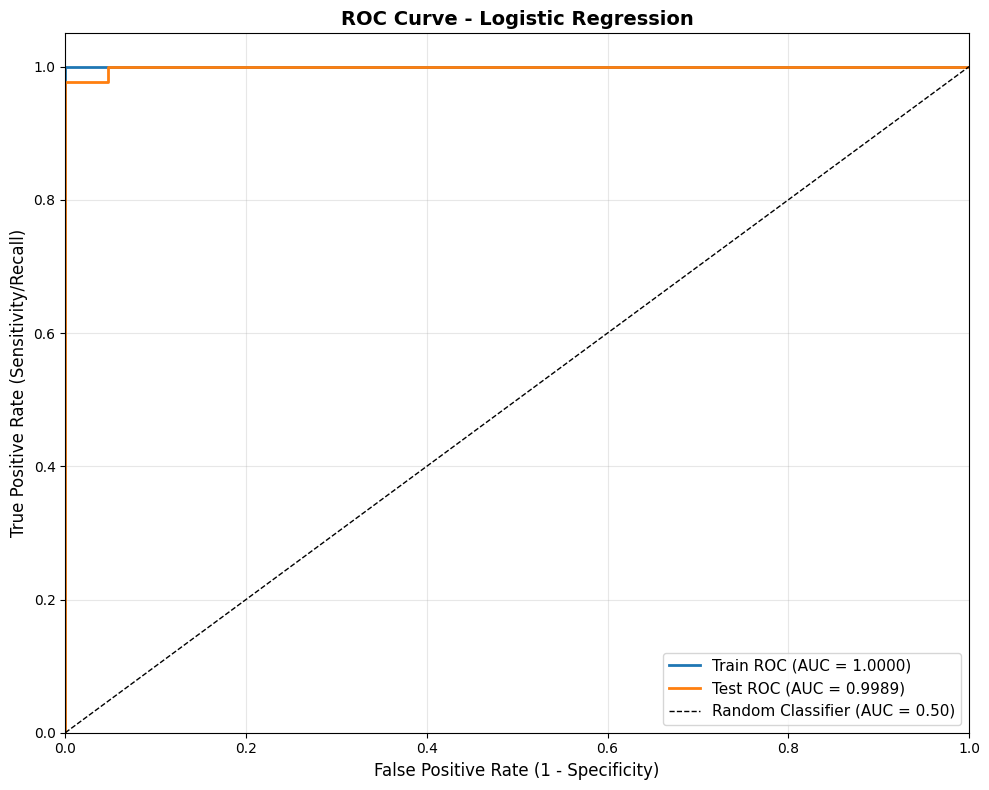

Train AUC: 1.0000
Test AUC: 0.9989


In [64]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42, max_iter=5000)
model.fit(X_train_scaled, y_train)

print("Model trained successfully!")
print(f"Model coefficients shape: {model.coef_.shape}")
print(f"Model intercept: {model.intercept_[0]:.4f}")

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy * 100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=["Benign", "Malignant"]))

# Get prediction probabilities for ROC and PR curves
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]  # Probability of positive class
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Prediction probabilities obtained")
print(f"Test probabilities range: [{y_test_proba.min():.4f}, {y_test_proba.max():.4f}]")

# Calculate ROC curve metrics
fpr_train, tpr_train, thresholds_roc_train = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, thresholds_roc_test = roc_curve(y_test, y_test_proba)

# Calculate AUC scores
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

print("Confusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"\nTrue Negatives (Benign correctly predicted): {cm[0][0]}")
print(f"False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]}")
print(f"True Positives (Malignant correctly predicted): {cm[1][1]}")

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.4f})", linewidth=2)
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUC = 0.50)", linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=12)
plt.ylabel("True Positive Rate (Sensitivity/Recall)", fontsize=12)
plt.title("ROC Curve - Logistic Regression", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Train AUC: {auc_train:.4f}")
print(f"Test AUC: {auc_test:.4f}")

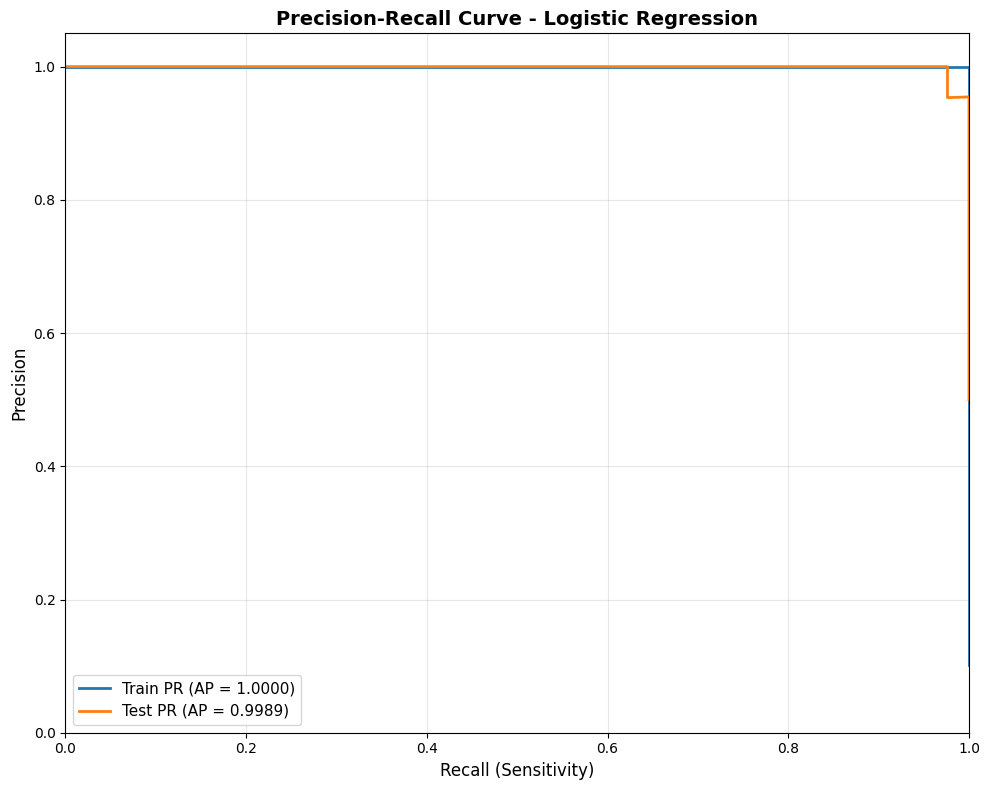

Train Average Precision: 1.0000
Test Average Precision: 0.9989


In [65]:
# Calculate Precision-Recall curve metrics
precision_train, recall_train, thresholds_pr_train = precision_recall_curve(y_train, y_train_proba)
precision_test, recall_test, thresholds_pr_test = precision_recall_curve(y_test, y_test_proba)

# Calculate Average Precision (AP) scores
ap_train = average_precision_score(y_train, y_train_proba)
ap_test = average_precision_score(y_test, y_test_proba)

# Plot PR curve
plt.figure(figsize=(10, 8))
plt.plot(recall_train, precision_train, label=f"Train PR (AP = {ap_train:.4f})", linewidth=2)
plt.plot(recall_test, precision_test, label=f"Test PR (AP = {ap_test:.4f})", linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall (Sensitivity)", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve - Logistic Regression", fontsize=14, fontweight="bold")
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Train Average Precision: {ap_train:.4f}")
print(f"Test Average Precision: {ap_test:.4f}")